# Predicting videogames sales through Bayesian reasoning
### Project carried out by [Diego Chinellato](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) for the Fundamentals of AI and KR course - module 3

## Abstract
*Financial data, such as data representing sales of a certain asset in a given economic sector, is intrinsically imbued with uncertainty, due to both the uncertainty of the financial market as well as the noise present in the data itself. In this report, probabilistic reasoning tools are applied to financial data concerning the sales in the videogames market. First, three different Bayesian Networks models are constructed either by explicitly defining the structure or by inferring it from the data. Then, for each model parameters are learned from the available data. Finally, inference techniques (both exact and approximate) are applied to perform probabilistic reasoning on the resulting model.*

This notebook describes the implementation of the Bayesian Network, as well as showing the queries and results.

## Data and preprocessing
*Dataset source: https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings*

This dataset contains a list of video games with sales greater than 100,000 copies. It was generated by a scrape of vgchartz.com.
Fields include:

* Name - The games name
* Platform - Platform of the games release (i.e. PC,PS4, etc.)
* Year - Year of the game's release
* Genre - Genre of the game
* Publisher - Publisher of the game
* NA_Sales - Sales in North America (in millions)
* EU_Sales - Sales in Europe (in millions)
* JP_Sales - Sales in Japan (in millions)
* Other_Sales - Sales in the rest of the world (in millions)
* Global_Sales - Total worldwide sales.
* Critic_score - Aggregate score compiled by Metacritic staff
* Critic_count - The number of critics used in coming up with the Criticscore
* User_score - Score by Metacritic's subscribers
* User_count - Number of users who gave the userscore
* Developer - Party responsible for creating the game
* Rating - The ESRB ratings

Before proceeding with the construction of the networks, we need to preprocess the data for several reasons:
* First, the are some features that have to be removed as they're not really helpful, such as the user and critic count which pretty much depend on the website from which the data was scraped from, or the name of the game. 
* Second, ``pmgpy`` unfortunately does not support learning of continuous variables, so all the non-discrete features in the dataset need to be discretized as well. 
* Finally, some data points representing for instance publishers or developers with a low number of games in the dataset were removed. Since there is already a huge number of unique values in these variables (which will, in turn, result in very big CDPs), this operation helps in having slightly smaller CDPs and to ease the general computational cost of the subsequent algorithms, while only slightly impacting the performances of the resulting networks.

In [140]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianModel
from pgmpy.estimators import PC, HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.independencies import Independencies
import numpy as np
import pandas as pd

In [154]:
df = pd.read_csv("videogames_sales.csv")
print(f'Dataset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

Dataset contains 16719 rows and 16 columns


,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [156]:
discrete_bins = 5
freq_threshold = 4

data = df.drop(columns=['Name', 'User_Count', 'Critic_Count', 'Rating']).dropna()
data['Year'] = data['Year'].astype(np.uint16)
data.loc[data['User_Score'] == 'tbd', ('User_Score')] = data[data["User_Score"] != 'tbd']["User_Score"].astype(float).mean() # mean of the column 
data['User_Score'] = data['User_Score'].astype(np.float64)
# drop records with low counts to help discretization
data = data[data['Platform'] != 'DC']

#for drop_rating in ('RP', 'K-A', 'AO'):
#    data = data[data['Rating'] != drop_rating]
for discretize_col in ('NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'User_Score'):
    bins = pd.qcut(data[discretize_col], q=discrete_bins, duplicates='drop')
    bin2int = {x: i for i, x in enumerate(bins.dtype.categories)}
    data[discretize_col] = bins.apply(lambda x: bin2int[x]).astype(np.uint8)
publishers_to_drop = data['Publisher'].value_counts() > freq_threshold
data = data[publishers_to_drop[data['Publisher']].values]
developers_to_drop = data['Developer'].value_counts() > freq_threshold
data = data[developers_to_drop[data['Developer']].values]

In [157]:
print(f'Dataset contains {data.shape[0]} rows and {data.shape[1]} columns')
data.head()

Dataset contains 5806 rows and 12 columns


,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Developer
0,Wii,2006,Sports,Nintendo,4,4,1,3,4,3,3,Nintendo
2,Wii,2008,Racing,Nintendo,4,4,1,3,4,4,3,Nintendo
3,Wii,2009,Sports,Nintendo,4,4,1,3,4,3,3,Nintendo
6,DS,2006,Platform,Nintendo,4,4,1,3,4,4,4,Nintendo
7,Wii,2006,Misc,Nintendo,4,4,1,3,4,0,1,Nintendo


## Network definition


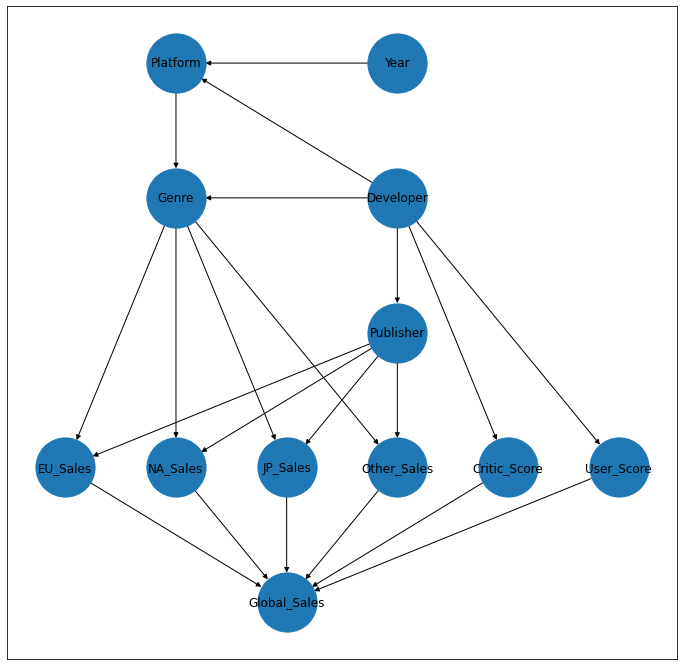

In [85]:
custom_model = BayesianModel([('Year', 'Platform'), ('Platform', 'Genre'),
                              ('Developer', 'Genre'), ('Developer', 'Platform'), ('Developer', 'Publisher'), #('Developer', 'Rating'), ('Developer', 'Global_Sales'),
                              ('Publisher', 'EU_Sales'), ('Publisher', 'NA_Sales'), ('Publisher', 'JP_Sales'), ('Publisher', 'Other_Sales'),
                              ('Developer', 'Critic_Score'), ('Developer', 'User_Score'), ('Developer', 'Critic_Score'), ('Developer', 'User_Score'),
                              ('Genre', 'EU_Sales'), ('Genre', 'NA_Sales'), ('Genre', 'JP_Sales'), ('Genre', 'Other_Sales'), # ('Genre', 'Rating'),
                              #('Platform', 'Rating'), ('Platform', 'EU_Sales'), ('Platform', 'NA_Sales'), ('Platform', 'JP_Sales'), ('Platform', 'Other_Sales'), 
                              ('EU_Sales', 'Global_Sales'), ('NA_Sales', 'Global_Sales'), ('JP_Sales', 'Global_Sales'), ('Other_Sales', 'Global_Sales'),
                              ('Critic_Score', 'Global_Sales'), ('User_Score', 'Global_Sales')])
pos = {'Year': [1.25, -0.5], 'Platform': [0.75, -0.5],
       'Genre': [0.75, -1.], 'Rating': [1.25, -1.], 'Developer': [1.25, -1],
       'Publisher': [1.25, -1.5],
       'Critic_Score': [1.5,  -2], 'User_Score': [1.75,  -2],
       'EU_Sales': [0.5, -2], 'NA_Sales': [0.75, -2], 'JP_Sales': [1, -2], 'Other_Sales': [1.25,  -2], 'Global_Sales': [1, -2.5]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=3500)

# Learning the network structure
materials:
https://www.frontiersin.org/articles/10.3389/fgene.2019.00524/full

https://arxiv.org/pdf/1502.02454.pdf#:~:text=The%20PC%20algorithm%20is%20the,data%2C%20e.g.%20gene%20expression%20datasets.


  0%|          | 19/1000000 [00:11<175:20:12,  1.58it/s]


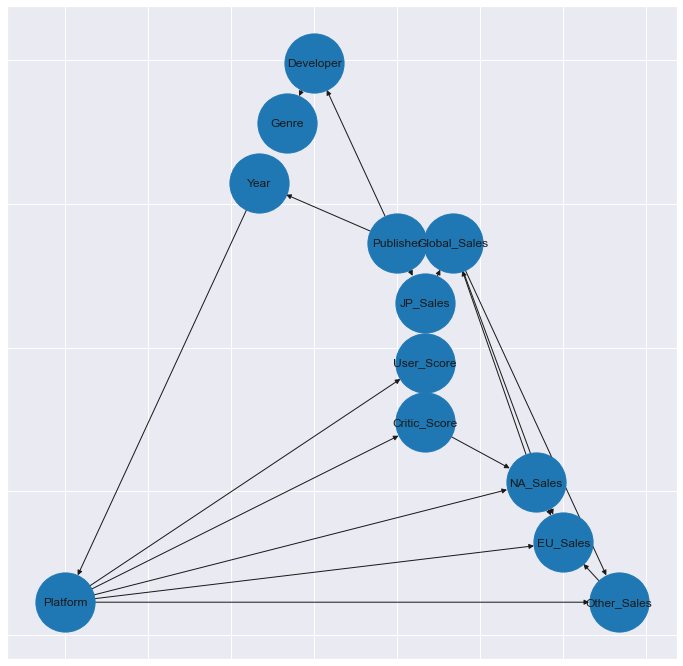

In [182]:
scorer = K2Score(data=data)
hc = HillClimbSearch(data=data)
hc_base_model = hc.estimate(scoring_method=scorer)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_base_model, pos=nx.drawing.layout.planar_layout(hc_base_model), ax=ax, node_size=3500)

hc_base_model = BayesianModel(hc_base_model.edges())

  0%|          | 18/1000000 [00:04<68:19:21,  4.07it/s]


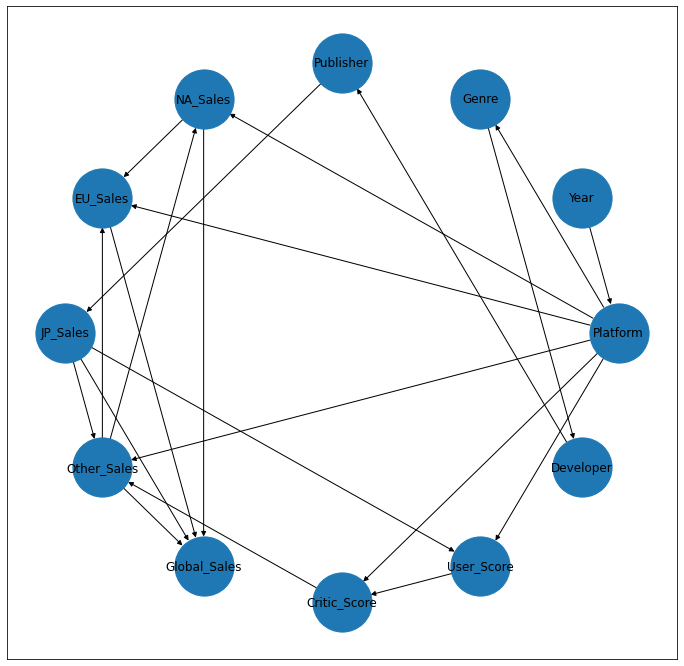

In [111]:
fixed_edges = [('EU_Sales', 'Global_Sales'), ('NA_Sales', 'Global_Sales'), 
               ('JP_Sales', 'Global_Sales'), ('Other_Sales', 'Global_Sales')]
black_list = [(f, 'Year') for f in ('Developer', 'Publisher', 'Genre', 'Platform', 'Global_Sales')] 
black_list += [('User_score', 'Critic_Score'), ('Critic_Score', 'User_Score'), ('Publisher', 'Developer')]

scorer = K2Score(data=data)
hc = HillClimbSearch(data=data)
hc_constr_model = hc.estimate(scoring_method=scorer, fixed_edges=fixed_edges, black_list=black_list)

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(hc_constr_model, pos=nx.drawing.layout.circular_layout(hc_constr_model), ax=ax, node_size=3500)

hc_constr_model = BayesianModel(hc_constr_model.edges())

Working for n conditional variables: 5: 100%|██████████| 5/5 [1:02:29<00:00, 749.85s/it]
C:\Users\chine\anaconda3\envs\bayes\lib\site-packages\pgmpy\base\DAG.py:1008: UserWarning: PDAG has no faithful extension (= no oriented DAG with the same v-structures as PDAG). Remaining undirected PDAG edges oriented arbitrarily.
  warn(


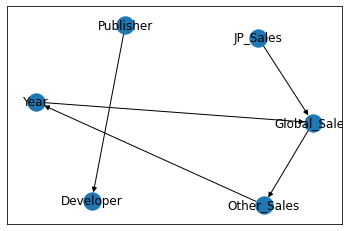

In [10]:
independencies = Independencies()
independencies.add_assertions([('EU_Sales', ('NA_Sales', 'JP_Sales', 'Other_Sales'), 'Global_Sales'),
                               ('NA_Sales', ('EU_Sales', 'JP_Sales', 'Other_Sales'), 'Global_Sales'),
                               ('JP_Sales', ('EU_Sales', 'NA_Sales', 'Other_Sales'), 'Global_Sales'),
                               ('Other_Sales', ('EU_Sales', 'NA_Sales', 'JP_Sales'), 'Global_Sales')])

pc = PC(data=data, independencies=independencies)
pc_model = pc.estimate(variant='parallel', ci_test='chi_square')
nx.draw_networkx(pc_model)

# Learning the networks parameters (CDPs)

In [112]:
models = [('custom', custom_model), ('hc base', hc_base_model), ('hc constrained', hc_constr_model)]
for name, model in models:
    print(f'computing CDTs for the {name} model')
    model.fit(data, estimator=MaximumLikelihoodEstimator)

fitting custom model


fitting hc base model
fitting hc constrained model


# Performing inference 
Proba
## Exact inference

In [113]:
from pgmpy.inference import VariableElimination
ves = [(name, VariableElimination(model)) for name, model in models]

### **Question**
    How do the two different scores (critics and users) affect global sales? Which one is more impactful?

In [114]:
scores = [(4,0), (3,1), (2, 2), (1, 3), (0, 4)]
for name, ve in ves:
    print(f"Model: {name}")
    for critic_score, user_score in scores:
        print(f"Scenario: critic score = {critic_score}, user score = {user_score}")
        print(ve.query(["Global_Sales"], {"Critic_Score": critic_score, "User_Score": user_score}, show_progress=False))
    print('*' * 42)

Model: custom
Scenario: critic score = 4, user score = 0
+-----------------+---------------------+
| Global_Sales    |   phi(Global_Sales) |
+=================+=====================+
| Global_Sales(0) |              0.1828 |
+-----------------+---------------------+
| Global_Sales(1) |              0.1828 |
+-----------------+---------------------+
| Global_Sales(2) |              0.1591 |
+-----------------+---------------------+
| Global_Sales(3) |              0.2002 |
+-----------------+---------------------+
| Global_Sales(4) |              0.2751 |
+-----------------+---------------------+
Scenario: critic score = 3, user score = 1
+-----------------+---------------------+
| Global_Sales    |   phi(Global_Sales) |
+=================+=====================+
| Global_Sales(0) |              0.1731 |
+-----------------+---------------------+
| Global_Sales(1) |              0.1994 |
+-----------------+---------------------+
| Global_Sales(2) |              0.1958 |
+-----------------

### **Answer**
    The three models produce different results in terms of absolute values of the resulting probability distribution; in particular, the custom model produces more "uniform" distributions compared to the more "pointy" distributions of the learned models. Still, there is a clear pattern emerging from the scenario, namely the fact that an higher critic score seems to be more important in obtaining an higher volume of sales.

### **Question**
    Which platforms should a certain developer choose to develop an Action game in 2016?

In [118]:
platforms = ['PS4', 'PS3', 'PC', 'XOne', 'X360', '3DS', 'WiiU']
answer = {}
for name, ve in ves:
    answer[name] = {}
    print(f"Model: {name}")
    print(f"Scenario: Ubisoft produces an Action game in 2016")
    for platform in platforms:
        print(f"Chosen platform: {platform}")
        answer[name][platform] = ve.query(["Global_Sales"], {"Developer": "Ubisoft", "Year": 2016, "Platform": platform}, show_progress=False)
    print('*' * 42)

Model: custom
Scenario: Ubisoft produces an Action game in 2016
Chosen platform: PS4
Chosen platform: PS3
Chosen platform: PC
Chosen platform: XOne
Chosen platform: X360
Chosen platform: 3DS
Chosen platform: WiiU
******************************************
Model: hc base
Scenario: Ubisoft produces an Action game in 2016
Chosen platform: PS4
Chosen platform: PS3
Chosen platform: PC
Chosen platform: XOne
Chosen platform: X360
Chosen platform: 3DS
Chosen platform: WiiU
******************************************
Model: hc constrained
Scenario: Ubisoft produces an Action game in 2016
Chosen platform: PS4
Chosen platform: PS3
Chosen platform: PC
Chosen platform: XOne
Chosen platform: X360
Chosen platform: 3DS
Chosen platform: WiiU
******************************************


In [177]:
answer['custom']['PS3'].values, answer['hc base']['PS3'].values

(array([0.14468486, 0.1725767 , 0.20773178, 0.27921427, 0.1957924 ]),
 array([0.09396835, 0.15792282, 0.22492304, 0.27242267, 0.25076311]))

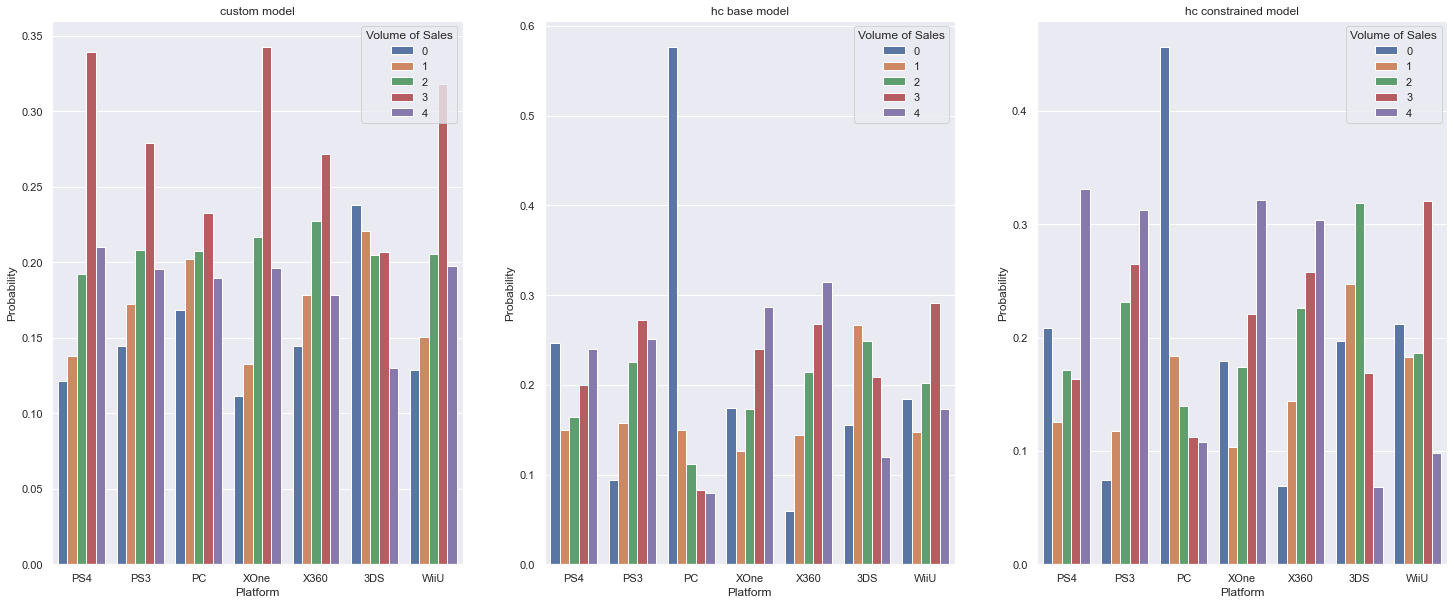

In [180]:
fig, axes = plt.subplots(1, 3, figsize=(25, 10))
plat2int = {p: i for i, p in enumerate(answer['custom'].keys())}
for ax, name in zip(axes, answer):
    ax.set_title(f"{name} model")
    probs = pd.DataFrame([[plat, int(sales), float(prob)] 
                    for plat in answer[name]
                    for sales, prob in enumerate(answer[name][plat].values)], columns=['Platform', 'Volume of Sales', 'Probability'])
    sns.barplot(x="Platform", y="Probability", hue="Volume of Sales", data=probs, ax=ax)

### Answer
    Again, the three models produce different results. For sure, the learned models suggests that it is not a good idea for the developer to choose PC as a platform to develop an Action-themed game in 2016. This insight is not directly confirmed by the custom model, but still we can notice that there is a good degree of uncertainty associated with that query, as the probabilities associated to each outcome are somewhat close together. Also, the custom model suggests that we might expect a good volume of sales by developing for the PS4, XOne and WiiU platforms (which makes sense, because they were the newest console available in 2016 and they're more adapt for Action-themed games than say the 3DS or the PC). 

In [62]:
for genre in ["Action", "Sports", "Racing", 'Role-Playing', 'Shooter']:
    print(f"Scenario: Ubisoft produces a {genre} game in 20")
    print(ve.query(["Global_Sales"], {"Developer": "Ubisoft", "Genre": genre}, show_progress=False))

Scenario: Ubisoft produces a Action game


Finding Elimination Order: : 100%|██████████| 9/9 [00:00<00:00, 1293.78it/s]

Eliminating: Year: 100%|██████████| 9/9 [00:00<00:00, 12.00it/s]    


+-----------------+---------------------+
| Global_Sales    |   phi(Global_Sales) |
+=================+=====================+
| Global_Sales(0) |              0.1577 |
+-----------------+---------------------+
| Global_Sales(1) |              0.1936 |
+-----------------+---------------------+
| Global_Sales(2) |              0.1989 |
+-----------------+---------------------+
| Global_Sales(3) |              0.2396 |
+-----------------+---------------------+
| Global_Sales(4) |              0.2102 |
+-----------------+---------------------+
Scenario: Ubisoft produces a Sports game


Finding Elimination Order: : 100%|██████████| 9/9 [00:00<00:00, 585.47it/s]

Eliminating: Year: 100%|██████████| 9/9 [00:00<00:00, 12.25it/s]    


+-----------------+---------------------+
| Global_Sales    |   phi(Global_Sales) |
+=================+=====================+
| Global_Sales(0) |              0.1735 |
+-----------------+---------------------+
| Global_Sales(1) |              0.2060 |
+-----------------+---------------------+
| Global_Sales(2) |              0.2187 |
+-----------------+---------------------+
| Global_Sales(3) |              0.2173 |
+-----------------+---------------------+
| Global_Sales(4) |              0.1844 |
+-----------------+---------------------+
Scenario: Ubisoft produces a Racing game


Finding Elimination Order: : 100%|██████████| 9/9 [00:00<00:00, 1292.41it/s]

Eliminating: Year: 100%|██████████| 9/9 [00:00<00:00, 10.51it/s]    


+-----------------+---------------------+
| Global_Sales    |   phi(Global_Sales) |
+=================+=====================+
| Global_Sales(0) |              0.1640 |
+-----------------+---------------------+
| Global_Sales(1) |              0.1948 |
+-----------------+---------------------+
| Global_Sales(2) |              0.2673 |
+-----------------+---------------------+
| Global_Sales(3) |              0.2655 |
+-----------------+---------------------+
| Global_Sales(4) |              0.1084 |
+-----------------+---------------------+
Scenario: Ubisoft produces a Role-Playing game


Finding Elimination Order: : 100%|██████████| 9/9 [00:00<00:00, 1132.95it/s]

Eliminating: Year: 100%|██████████| 9/9 [00:00<00:00, 11.76it/s]    


+-----------------+---------------------+
| Global_Sales    |   phi(Global_Sales) |
+=================+=====================+
| Global_Sales(0) |              0.1742 |
+-----------------+---------------------+
| Global_Sales(1) |              0.3158 |
+-----------------+---------------------+
| Global_Sales(2) |              0.2586 |
+-----------------+---------------------+
| Global_Sales(3) |              0.1385 |
+-----------------+---------------------+
| Global_Sales(4) |              0.1129 |
+-----------------+---------------------+
Scenario: Ubisoft produces a Adventure game


Finding Elimination Order: : 100%|██████████| 9/9 [00:00<00:00, 1274.95it/s]

Eliminating: Year: 100%|██████████| 9/9 [00:00<00:00, 10.71it/s]    

+-----------------+---------------------+
| Global_Sales    |   phi(Global_Sales) |
+=================+=====================+
| Global_Sales(0) |              0.1653 |
+-----------------+---------------------+
| Global_Sales(1) |              0.2394 |
+-----------------+---------------------+
| Global_Sales(2) |              0.2297 |
+-----------------+---------------------+
| Global_Sales(3) |              0.2022 |
+-----------------+---------------------+
| Global_Sales(4) |              0.1633 |
+-----------------+---------------------+
